# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples
- https://www.kaggle.com/snakayama/lightgbm-using-optuna-optuna-lightgbm

In [1]:
TGT='Reply'
PRFX='Reply0411_1'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(5e5)#int(1e5)
trnsz = int(5e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(500000, 24)


retwt          0.112638
reply          0.027980
like           0.439010
retwt_cmmnt    0.007676
dtype: float64

CPU times: user 5.19 s, sys: 647 ms, total: 5.83 s
Wall time: 6.32 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(1850000, 24)


retwt          0.112795
reply          0.027393
like           0.439040
retwt_cmmnt    0.007702
dtype: float64

CPU times: user 20.5 s, sys: 1.99 s, total: 22.5 s
Wall time: 23.3 s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(500000, 24) 0.101354
1850000 50677 500000 50677


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
9,101\t137\t48201\t10133\t44026\t10884\t11305\t9...,NaN,24669C0DADEA57A75F6BE24CAC0ACCB9,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1580948734,A6E0653718DB85566D3E6D1E2989AC6D,145,61,False,1522591408,06E9B9E30FB6A7F37CA6B42264C30103,407,385,False,1274938010,True,False,True,False,False
11,101\t2341\t7911\t121\t12236\t7596\t7431\t12290...,NaN,E15A666B6A975581F5CE3F2286CDB408,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581344753,74BD974C794C3C2D604E92F9402AB810,318,252,False,1464834037,06E9B9E30FB6A7F37CA6B42264C30103,407,385,False,1274938010,True,False,True,False,False
26,101\t144\t87051\t10354\t16874\t196\t10117\t172...,NaN,D8334D0798821B6A99A9C7A4C9E4E3E1,NaN,8FBB6E6890E2ED0F608F83345CB5EA2F,FFA7BC68DEEFEE9FE34F150D60FEA189,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581149159,4CA2E59BBCCB899954E82B01D61C8DF1,16974,612,False,1397475686,06E9CB2FE3EE244FC5D3E2A7E0B7A460,66,512,False,1498734232,False,False,True,False,False
96,101\t11589\t39520\t18487\t58136\t10121\t10911\...,NaN,0C55DCB7494C90953ACE5E70A46B8AA9,NaN,NaN,NaN,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581470640,58867654CB709C6FBA4F332ED479EF1A,418,554,False,1354395470,06E9F8C1FB619A5AE34B3BE57632DB16,178,339,False,1538938782,True,False,True,True,False
303,101\t65000\t112\t188\t19556\t12172\t10133\t218...,NaN,3058691BBE196B9A3702A8E7584944E9,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1580980182,B31DCBBAE66B1E22B1531F77538E88E7,19,440,False,1476507467,06EADF03A34F162DE8051C27C439F6BB,172,167,False,1418024844,True,False,True,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-11 20:29:29 start
2020-04-11 20:29:45 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 20:30:07 freq of tags
2020-04-11 20:30:15 done
CPU times: user 39.9 s, sys: 4.19 s, total: 44.1 s
Wall time: 46.7 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-11 20:30:16 start
2020-04-11 20:30:29 freq of columns using CountEncoder
2020-04-11 20:30:47 freq of tags
2020-04-11 20:30:54 done
CPU times: user 33.5 s, sys: 3.82 s, total: 37.3 s
Wall time: 39 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'u1inu2',
       'u2inu1', 'len_toks', 'n_media_Photo', 'n_media_Video', 'n_media_GIF',
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media', 'has_domns',
       'n_domns', 'dayofweek', 'hour', 'tmdlta_u2u1', 'tmdlta_twtu1',
       'tmdlta_twtu2', 'twt_age', 'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp',
       'frq_lang', 'frq_u1id', 'frq_u1_fllwing_cnt', 'frq_u1_vrfed',
       'frq_u2id', 'frq_u2_fllwer_cnt', 'frq_u2_vrfed', 'frq_u1_fllw_u2',
       'frq_n_media_Photo', 'frq_n_media_Video', 'frq_n_media_GIF',
       'frq_has_hshtgs', 'frq_n_hshtgs', 'frq_has_media', 'frq_n_media',
       'frq_has_domns', 'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2',
       'frq_langhour', 'sumfrq_hshtgs', 

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 36.9 s, sys: 7.03 s, total: 44 s
Wall time: 45.4 s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [16]:
print(len(cols_feat))
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
 'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
 'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
 'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
 'frq_u1u2',
#  'frq_langhour',
 'sumfrq_hshtgs',
#  'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
 'sumfrq_domns',
#  'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
 'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]
print(len(cols_feat))

86
36


In [17]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [18]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}
results['params'] = params

In [19]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.271637	vl's binary_logloss: 0.280744
[200]	tr's binary_logloss: 0.265318	vl's binary_logloss: 0.280378
[300]	tr's binary_logloss: 0.259913	vl's binary_logloss: 0.280298
[400]	tr's binary_logloss: 0.254982	vl's binary_logloss: 0.280271
Early stopping, best iteration is:
[349]	tr's binary_logloss: 0.257483	vl's binary_logloss: 0.280161


tune_feature_fraction, val_score: 0.280161:  14%|#4        | 1/7 [00:22<02:17, 22.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270884	vl's binary_logloss: 0.280999
[200]	tr's binary_logloss: 0.263947	vl's binary_logloss: 0.280682
[300]	tr's binary_logloss: 0.258027	vl's binary_logloss: 0.280494
Early stopping, best iteration is:
[299]	tr's binary_logloss: 0.258086	vl's binary_logloss: 0.280489


tune_feature_fraction, val_score: 0.280161:  29%|##8       | 2/7 [00:45<01:53, 22.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269552	vl's binary_logloss: 0.281142
[200]	tr's binary_logloss: 0.262368	vl's binary_logloss: 0.280843
[300]	tr's binary_logloss: 0.25614	vl's binary_logloss: 0.280811
Early stopping, best iteration is:
[235]	tr's binary_logloss: 0.260013	vl's binary_logloss: 0.280698


tune_feature_fraction, val_score: 0.280161:  43%|####2     | 3/7 [01:03<01:24, 21.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26893	vl's binary_logloss: 0.281275
[200]	tr's binary_logloss: 0.261427	vl's binary_logloss: 0.280844
[300]	tr's binary_logloss: 0.255293	vl's binary_logloss: 0.280769
Early stopping, best iteration is:
[259]	tr's binary_logloss: 0.257684	vl's binary_logloss: 0.28067


tune_feature_fraction, val_score: 0.280161:  57%|#####7    | 4/7 [01:23<01:03, 21.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.267904	vl's binary_logloss: 0.281648
[200]	tr's binary_logloss: 0.259742	vl's binary_logloss: 0.281442
[300]	tr's binary_logloss: 0.253226	vl's binary_logloss: 0.281521
Early stopping, best iteration is:
[267]	tr's binary_logloss: 0.25541	vl's binary_logloss: 0.281399


tune_feature_fraction, val_score: 0.280161:  71%|#######1  | 5/7 [01:37<00:38, 19.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266975	vl's binary_logloss: 0.282258
[200]	tr's binary_logloss: 0.259155	vl's binary_logloss: 0.282029
Early stopping, best iteration is:
[183]	tr's binary_logloss: 0.260287	vl's binary_logloss: 0.281885


tune_feature_fraction, val_score: 0.280161:  86%|########5 | 6/7 [01:47<00:16, 16.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266203	vl's binary_logloss: 0.28268
[200]	tr's binary_logloss: 0.257657	vl's binary_logloss: 0.282604
Early stopping, best iteration is:
[145]	tr's binary_logloss: 0.261932	vl's binary_logloss: 0.282521


tune_num_leaves, val_score: 0.280161:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252789	vl's binary_logloss: 0.28023
Early stopping, best iteration is:
[87]	tr's binary_logloss: 0.255585	vl's binary_logloss: 0.280157


tune_num_leaves, val_score: 0.280157:   5%|5         | 1/20 [00:08<02:36,  8.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252789	vl's binary_logloss: 0.28023
Early stopping, best iteration is:
[87]	tr's binary_logloss: 0.255585	vl's binary_logloss: 0.280157


tune_num_leaves, val_score: 0.280157:  10%|#         | 2/20 [00:16<02:28,  8.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.243395	vl's binary_logloss: 0.279848
[200]	tr's binary_logloss: 0.221511	vl's binary_logloss: 0.280257
Early stopping, best iteration is:
[101]	tr's binary_logloss: 0.243182	vl's binary_logloss: 0.279836


tune_num_leaves, val_score: 0.279836:  15%|#5        | 3/20 [00:27<02:32,  8.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242602	vl's binary_logloss: 0.27984
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.244692	vl's binary_logloss: 0.279764


tune_num_leaves, val_score: 0.279764:  20%|##        | 4/20 [00:37<02:28,  9.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263661	vl's binary_logloss: 0.279824
[200]	tr's binary_logloss: 0.253061	vl's binary_logloss: 0.279856
Early stopping, best iteration is:
[193]	tr's binary_logloss: 0.253787	vl's binary_logloss: 0.279749


tune_num_leaves, val_score: 0.279749:  25%|##5       | 5/20 [00:47<02:21,  9.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.24515	vl's binary_logloss: 0.279913
Early stopping, best iteration is:
[88]	tr's binary_logloss: 0.248108	vl's binary_logloss: 0.279862


tune_num_leaves, val_score: 0.279749:  30%|###       | 6/20 [00:56<02:12,  9.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.258118	vl's binary_logloss: 0.279928
[200]	tr's binary_logloss: 0.244665	vl's binary_logloss: 0.280307
Early stopping, best iteration is:
[105]	tr's binary_logloss: 0.257297	vl's binary_logloss: 0.279921


tune_num_leaves, val_score: 0.279749:  35%|###5      | 7/20 [01:04<01:58,  9.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.235331	vl's binary_logloss: 0.280105
Early stopping, best iteration is:
[92]	tr's binary_logloss: 0.23779	vl's binary_logloss: 0.279981


tune_num_leaves, val_score: 0.279749:  40%|####      | 8/20 [01:15<01:56,  9.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.243118	vl's binary_logloss: 0.279887
Early stopping, best iteration is:
[84]	tr's binary_logloss: 0.247481	vl's binary_logloss: 0.279793


tune_num_leaves, val_score: 0.279749:  45%|####5     | 9/20 [01:25<01:46,  9.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.241543	vl's binary_logloss: 0.28004
Early stopping, best iteration is:
[87]	tr's binary_logloss: 0.245182	vl's binary_logloss: 0.279913


tune_num_leaves, val_score: 0.279749:  50%|#####     | 10/20 [01:35<01:37,  9.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.27947	vl's binary_logloss: 0.282922
[200]	tr's binary_logloss: 0.276037	vl's binary_logloss: 0.281753
[300]	tr's binary_logloss: 0.273498	vl's binary_logloss: 0.28126
[400]	tr's binary_logloss: 0.271411	vl's binary_logloss: 0.280907
[500]	tr's binary_logloss: 0.269358	vl's binary_logloss: 0.280741
[600]	tr's binary_logloss: 0.267521	vl's binary_logloss: 0.280598
Early stopping, best iteration is:
[581]	tr's binary_logloss: 0.267852	vl's binary_logloss: 0.280579


tune_num_leaves, val_score: 0.279749:  55%|#####5    | 11/20 [01:50<01:41, 11.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268523	vl's binary_logloss: 0.28041
[200]	tr's binary_logloss: 0.260767	vl's binary_logloss: 0.280065
[300]	tr's binary_logloss: 0.253926	vl's binary_logloss: 0.280121
Early stopping, best iteration is:
[211]	tr's binary_logloss: 0.259827	vl's binary_logloss: 0.280035


tune_num_leaves, val_score: 0.279749:  60%|######    | 12/20 [01:59<01:25, 10.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264138	vl's binary_logloss: 0.280116
[200]	tr's binary_logloss: 0.253858	vl's binary_logloss: 0.280071
Early stopping, best iteration is:
[181]	tr's binary_logloss: 0.255669	vl's binary_logloss: 0.279964


tune_num_leaves, val_score: 0.279749:  65%|######5   | 13/20 [02:09<01:12, 10.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.2331	vl's binary_logloss: 0.280385
Early stopping, best iteration is:
[70]	tr's binary_logloss: 0.243552	vl's binary_logloss: 0.280131


tune_num_leaves, val_score: 0.279749:  70%|#######   | 14/20 [02:19<01:01, 10.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.291685	vl's binary_logloss: 0.292068
[200]	tr's binary_logloss: 0.288558	vl's binary_logloss: 0.288958
[300]	tr's binary_logloss: 0.287354	vl's binary_logloss: 0.28781
[400]	tr's binary_logloss: 0.286717	vl's binary_logloss: 0.28727
[500]	tr's binary_logloss: 0.286323	vl's binary_logloss: 0.28697
[600]	tr's binary_logloss: 0.286054	vl's binary_logloss: 0.286762
[700]	tr's binary_logloss: 0.285852	vl's binary_logloss: 0.286612
[800]	tr's binary_logloss: 0.285688	vl's binary_logloss: 0.286491
[900]	tr's binary_logloss: 0.285553	vl's binary_logloss: 0.286383
[1000]	tr's binary_logloss: 0.28544	vl's binary_logloss: 0.286307
[1100]	tr's binary_logloss: 0.28534	vl's binary_logloss: 0.286259
[1200]	tr's binary_logloss: 0.285253	vl's binary_logloss: 0.286206
[1300]	tr's binary_logloss: 0.285177	vl's binary_logloss: 0.286166
[1400]	tr's binary_logloss: 0.285109	vl's binary_logloss: 0.286145
[1500]	tr's bi

tune_num_leaves, val_score: 0.279749:  75%|#######5  | 15/20 [03:06<01:47, 21.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.236802	vl's binary_logloss: 0.280168
Early stopping, best iteration is:
[95]	tr's binary_logloss: 0.238464	vl's binary_logloss: 0.280061


tune_num_leaves, val_score: 0.279749:  80%|########  | 16/20 [03:17<01:13, 18.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.259929	vl's binary_logloss: 0.279928
[200]	tr's binary_logloss: 0.247114	vl's binary_logloss: 0.280115
Early stopping, best iteration is:
[161]	tr's binary_logloss: 0.251694	vl's binary_logloss: 0.279908


tune_num_leaves, val_score: 0.279749:  85%|########5 | 17/20 [03:27<00:47, 15.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.247872	vl's binary_logloss: 0.279809
Early stopping, best iteration is:
[99]	tr's binary_logloss: 0.248152	vl's binary_logloss: 0.279801


tune_num_leaves, val_score: 0.279749:  90%|######### | 18/20 [03:37<00:27, 13.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269258	vl's binary_logloss: 0.280534
[200]	tr's binary_logloss: 0.26184	vl's binary_logloss: 0.280272
[300]	tr's binary_logloss: 0.255419	vl's binary_logloss: 0.280299
[400]	tr's binary_logloss: 0.249773	vl's binary_logloss: 0.28032
Early stopping, best iteration is:
[363]	tr's binary_logloss: 0.251968	vl's binary_logloss: 0.280164


tune_num_leaves, val_score: 0.279749:  95%|#########5| 19/20 [03:50<00:13, 13.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.238604	vl's binary_logloss: 0.280073
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.240752	vl's binary_logloss: 0.280019


tune_num_leaves, val_score: 0.279749: 100%|##########| 20/20 [04:01<00:00, 12.07s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.279749:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265592	vl's binary_logloss: 0.280352
[200]	tr's binary_logloss: 0.255279	vl's binary_logloss: 0.280241
Early stopping, best iteration is:
[157]	tr's binary_logloss: 0.259462	vl's binary_logloss: 0.280052


tune_bagging_fraction_and_bagging_freq, val_score: 0.279749:  10%|#         | 1/10 [00:09<01:27,  9.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264796	vl's binary_logloss: 0.280475
Early stopping, best iteration is:
[97]	tr's binary_logloss: 0.265197	vl's binary_logloss: 0.280418


tune_bagging_fraction_and_bagging_freq, val_score: 0.279749:  20%|##        | 2/10 [00:18<01:14,  9.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263917	vl's binary_logloss: 0.280268
[200]	tr's binary_logloss: 0.253676	vl's binary_logloss: 0.280269
Early stopping, best iteration is:
[160]	tr's binary_logloss: 0.257339	vl's binary_logloss: 0.280172


tune_bagging_fraction_and_bagging_freq, val_score: 0.279749:  30%|###       | 3/10 [00:28<01:08,  9.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263739	vl's binary_logloss: 0.280389
[200]	tr's binary_logloss: 0.25365	vl's binary_logloss: 0.280247
Early stopping, best iteration is:
[196]	tr's binary_logloss: 0.254062	vl's binary_logloss: 0.280229


tune_bagging_fraction_and_bagging_freq, val_score: 0.279749:  40%|####      | 4/10 [00:41<01:03, 10.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266103	vl's binary_logloss: 0.281045
[200]	tr's binary_logloss: 0.255857	vl's binary_logloss: 0.281599
Early stopping, best iteration is:
[106]	tr's binary_logloss: 0.265444	vl's binary_logloss: 0.280972


tune_bagging_fraction_and_bagging_freq, val_score: 0.279749:  50%|#####     | 5/10 [00:49<00:48,  9.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26486	vl's binary_logloss: 0.280407
[200]	tr's binary_logloss: 0.254436	vl's binary_logloss: 0.280083
Early stopping, best iteration is:
[172]	tr's binary_logloss: 0.257064	vl's binary_logloss: 0.280026


tune_bagging_fraction_and_bagging_freq, val_score: 0.279749:  60%|######    | 6/10 [01:01<00:41, 10.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265315	vl's binary_logloss: 0.280142
[200]	tr's binary_logloss: 0.255022	vl's binary_logloss: 0.280177
Early stopping, best iteration is:
[189]	tr's binary_logloss: 0.255973	vl's binary_logloss: 0.280005


tune_bagging_fraction_and_bagging_freq, val_score: 0.279749:  70%|#######   | 7/10 [01:13<00:33, 11.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264168	vl's binary_logloss: 0.280288
[200]	tr's binary_logloss: 0.254081	vl's binary_logloss: 0.280297
Early stopping, best iteration is:
[180]	tr's binary_logloss: 0.255876	vl's binary_logloss: 0.28016


tune_bagging_fraction_and_bagging_freq, val_score: 0.279749:  80%|########  | 8/10 [01:25<00:22, 11.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26559	vl's binary_logloss: 0.280271
[200]	tr's binary_logloss: 0.255239	vl's binary_logloss: 0.280483
Early stopping, best iteration is:
[165]	tr's binary_logloss: 0.258649	vl's binary_logloss: 0.280143


tune_bagging_fraction_and_bagging_freq, val_score: 0.279749:  90%|######### | 9/10 [01:36<00:11, 11.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266064	vl's binary_logloss: 0.280955
[200]	tr's binary_logloss: 0.255975	vl's binary_logloss: 0.281131
Early stopping, best iteration is:
[131]	tr's binary_logloss: 0.262683	vl's binary_logloss: 0.280861


tune_bagging_fraction_and_bagging_freq, val_score: 0.279749: 100%|##########| 10/10 [01:45<00:00, 10.53s/it]
tune_feature_fraction, val_score: 0.279749:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.262979	vl's binary_logloss: 0.280139
[200]	tr's binary_logloss: 0.252126	vl's binary_logloss: 0.280173
Early stopping, best iteration is:
[137]	tr's binary_logloss: 0.258682	vl's binary_logloss: 0.280089


tune_feature_fraction, val_score: 0.279749:  33%|###3      | 1/3 [00:08<00:17,  8.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.262549	vl's binary_logloss: 0.280104
Early stopping, best iteration is:
[96]	tr's binary_logloss: 0.263142	vl's binary_logloss: 0.28007


tune_feature_fraction, val_score: 0.279749:  67%|######6   | 2/3 [00:15<00:08,  8.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.262377	vl's binary_logloss: 0.28025
Early stopping, best iteration is:
[92]	tr's binary_logloss: 0.263514	vl's binary_logloss: 0.280189


tune_feature_fraction, val_score: 0.279749: 100%|##########| 3/3 [00:22<00:00,  7.60s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.279749:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263774	vl's binary_logloss: 0.279782
[200]	tr's binary_logloss: 0.253461	vl's binary_logloss: 0.279754
[300]	tr's binary_logloss: 0.244741	vl's binary_logloss: 0.279712
Early stopping, best iteration is:
[245]	tr's binary_logloss: 0.249621	vl's binary_logloss: 0.279677


tune_lambda_l1_and_lambda_l2, val_score: 0.279677:   5%|5         | 1/20 [00:12<03:47, 11.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263535	vl's binary_logloss: 0.279975
[200]	tr's binary_logloss: 0.253164	vl's binary_logloss: 0.279967
Early stopping, best iteration is:
[147]	tr's binary_logloss: 0.258053	vl's binary_logloss: 0.279859


tune_lambda_l1_and_lambda_l2, val_score: 0.279677:  10%|#         | 2/20 [00:21<03:19, 11.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266039	vl's binary_logloss: 0.279809
[200]	tr's binary_logloss: 0.257549	vl's binary_logloss: 0.279673
Early stopping, best iteration is:
[184]	tr's binary_logloss: 0.258879	vl's binary_logloss: 0.279621


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  15%|#5        | 3/20 [00:32<03:11, 11.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263959	vl's binary_logloss: 0.279823
[200]	tr's binary_logloss: 0.254239	vl's binary_logloss: 0.279846
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.257926	vl's binary_logloss: 0.279713


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  20%|##        | 4/20 [00:42<02:51, 10.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263661	vl's binary_logloss: 0.279824
Early stopping, best iteration is:
[99]	tr's binary_logloss: 0.263896	vl's binary_logloss: 0.279809


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  25%|##5       | 5/20 [00:49<02:24,  9.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266439	vl's binary_logloss: 0.279891
[200]	tr's binary_logloss: 0.258405	vl's binary_logloss: 0.279779
Early stopping, best iteration is:
[195]	tr's binary_logloss: 0.258825	vl's binary_logloss: 0.279754


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  30%|###       | 6/20 [01:01<02:26, 10.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263523	vl's binary_logloss: 0.28026
[200]	tr's binary_logloss: 0.252751	vl's binary_logloss: 0.280015
[300]	tr's binary_logloss: 0.243463	vl's binary_logloss: 0.280239
Early stopping, best iteration is:
[206]	tr's binary_logloss: 0.252205	vl's binary_logloss: 0.279997


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  35%|###5      | 7/20 [01:12<02:18, 10.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263666	vl's binary_logloss: 0.279827
[200]	tr's binary_logloss: 0.252992	vl's binary_logloss: 0.279881
Early stopping, best iteration is:
[160]	tr's binary_logloss: 0.257002	vl's binary_logloss: 0.279783


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  40%|####      | 8/20 [01:22<02:02, 10.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263566	vl's binary_logloss: 0.27996
[200]	tr's binary_logloss: 0.252998	vl's binary_logloss: 0.279918
Early stopping, best iteration is:
[188]	tr's binary_logloss: 0.254101	vl's binary_logloss: 0.279903


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  45%|####5     | 9/20 [01:31<01:51, 10.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263661	vl's binary_logloss: 0.279824
[200]	tr's binary_logloss: 0.253061	vl's binary_logloss: 0.279856
Early stopping, best iteration is:
[193]	tr's binary_logloss: 0.253787	vl's binary_logloss: 0.279749


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  50%|#####     | 10/20 [01:42<01:43, 10.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265982	vl's binary_logloss: 0.27991
[200]	tr's binary_logloss: 0.257603	vl's binary_logloss: 0.279721
[300]	tr's binary_logloss: 0.250602	vl's binary_logloss: 0.279985
Early stopping, best iteration is:
[246]	tr's binary_logloss: 0.254559	vl's binary_logloss: 0.279684


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  55%|#####5    | 11/20 [01:57<01:45, 11.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263717	vl's binary_logloss: 0.28006
[200]	tr's binary_logloss: 0.253055	vl's binary_logloss: 0.280272
Early stopping, best iteration is:
[105]	tr's binary_logloss: 0.263092	vl's binary_logloss: 0.280052


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  60%|######    | 12/20 [02:04<01:23, 10.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265111	vl's binary_logloss: 0.279683
[200]	tr's binary_logloss: 0.256086	vl's binary_logloss: 0.279763
Early stopping, best iteration is:
[117]	tr's binary_logloss: 0.26344	vl's binary_logloss: 0.279656


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  65%|######5   | 13/20 [02:14<01:10, 10.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266071	vl's binary_logloss: 0.279929
[200]	tr's binary_logloss: 0.257682	vl's binary_logloss: 0.279765
Early stopping, best iteration is:
[188]	tr's binary_logloss: 0.258535	vl's binary_logloss: 0.27969


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  70%|#######   | 14/20 [02:26<01:05, 10.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264252	vl's binary_logloss: 0.279671
[200]	tr's binary_logloss: 0.254276	vl's binary_logloss: 0.279724
Early stopping, best iteration is:
[181]	tr's binary_logloss: 0.255996	vl's binary_logloss: 0.279628


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  75%|#######5  | 15/20 [02:41<01:00, 12.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263781	vl's binary_logloss: 0.280134
[200]	tr's binary_logloss: 0.253209	vl's binary_logloss: 0.280013
Early stopping, best iteration is:
[181]	tr's binary_logloss: 0.255199	vl's binary_logloss: 0.27989


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  80%|########  | 16/20 [02:57<00:52, 13.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263632	vl's binary_logloss: 0.280149
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.264522	vl's binary_logloss: 0.280095


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  85%|########5 | 17/20 [03:07<00:37, 12.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264036	vl's binary_logloss: 0.279872
[200]	tr's binary_logloss: 0.254105	vl's binary_logloss: 0.279948
Early stopping, best iteration is:
[154]	tr's binary_logloss: 0.25829	vl's binary_logloss: 0.279775


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  90%|######### | 18/20 [03:22<00:26, 13.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263519	vl's binary_logloss: 0.280096
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.263805	vl's binary_logloss: 0.280083


tune_lambda_l1_and_lambda_l2, val_score: 0.279621:  95%|#########5| 19/20 [03:35<00:12, 12.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263669	vl's binary_logloss: 0.28001
[200]	tr's binary_logloss: 0.253127	vl's binary_logloss: 0.280236
Early stopping, best iteration is:
[101]	tr's binary_logloss: 0.263573	vl's binary_logloss: 0.28


tune_lambda_l1_and_lambda_l2, val_score: 0.279621: 100%|##########| 20/20 [03:48<00:00, 11.42s/it]
tune_min_child_samples, val_score: 0.279621:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266071	vl's binary_logloss: 0.279839
[200]	tr's binary_logloss: 0.257828	vl's binary_logloss: 0.27965
[300]	tr's binary_logloss: 0.251113	vl's binary_logloss: 0.27985
Early stopping, best iteration is:
[201]	tr's binary_logloss: 0.257723	vl's binary_logloss: 0.279641


tune_min_child_samples, val_score: 0.279621:  20%|##        | 1/5 [00:20<01:21, 20.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266055	vl's binary_logloss: 0.279903
[200]	tr's binary_logloss: 0.257422	vl's binary_logloss: 0.279729
Early stopping, best iteration is:
[184]	tr's binary_logloss: 0.258792	vl's binary_logloss: 0.279677


tune_min_child_samples, val_score: 0.279621:  40%|####      | 2/5 [00:40<01:00, 20.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265984	vl's binary_logloss: 0.279769
[200]	tr's binary_logloss: 0.257395	vl's binary_logloss: 0.279618
[300]	tr's binary_logloss: 0.250555	vl's binary_logloss: 0.279874
Early stopping, best iteration is:
[241]	tr's binary_logloss: 0.254646	vl's binary_logloss: 0.279575


tune_min_child_samples, val_score: 0.279575:  60%|######    | 3/5 [01:02<00:41, 20.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266039	vl's binary_logloss: 0.280033
[200]	tr's binary_logloss: 0.257605	vl's binary_logloss: 0.279942
Early stopping, best iteration is:
[194]	tr's binary_logloss: 0.258158	vl's binary_logloss: 0.279875


tune_min_child_samples, val_score: 0.279575:  80%|########  | 4/5 [01:22<00:20, 20.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26606	vl's binary_logloss: 0.279906
[200]	tr's binary_logloss: 0.257392	vl's binary_logloss: 0.27975
Early stopping, best iteration is:
[194]	tr's binary_logloss: 0.257855	vl's binary_logloss: 0.279672


tune_min_child_samples, val_score: 0.279575: 100%|##########| 5/5 [01:38<00:00, 19.77s/it]


CPU times: user 1h 10min 2s, sys: 1h 43min 23s, total: 2h 53min 26s
Wall time: 13min 33s


## best_params

In [20]:
best_params

{'lambda_l1': 7.593990354012815,
 'lambda_l2': 1.770022013357123e-07,
 'num_leaves': 64,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 25}

## tr vl trajec

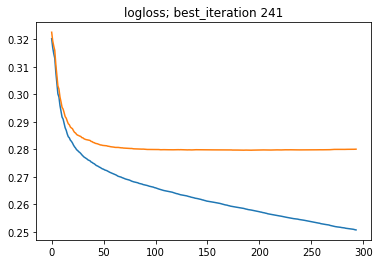

In [21]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

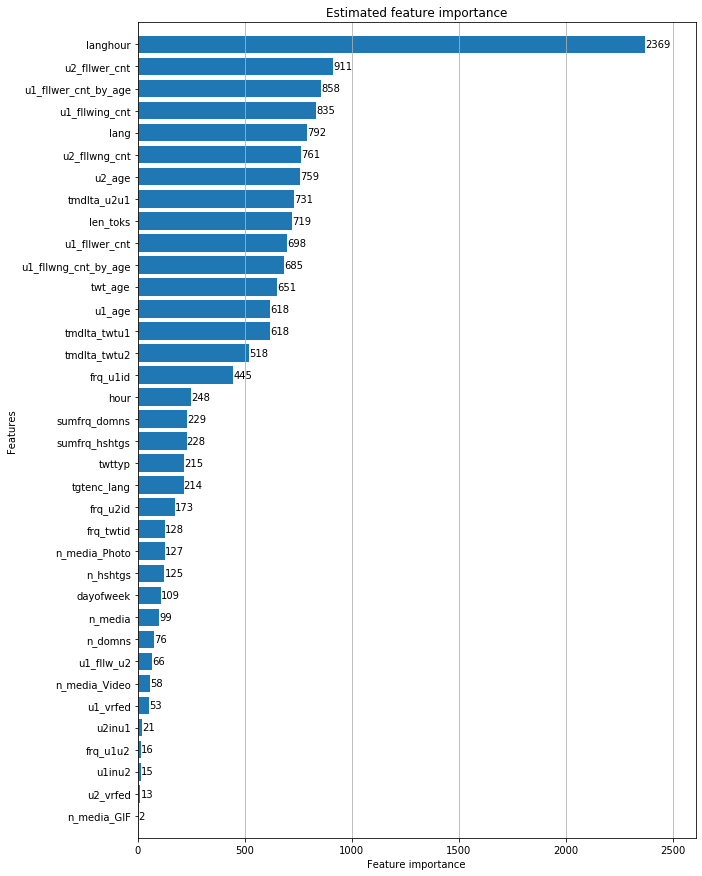

In [22]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [23]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
28,langhour,2369
5,u2_fllwer_cnt,911
26,u1_fllwer_cnt_by_age,858
3,u1_fllwing_cnt,835
1,lang,792
6,u2_fllwng_cnt,761
25,u2_age,759
20,tmdlta_u2u1,731
11,len_toks,719
2,u1_fllwer_cnt,698


In [24]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 2369),
 ('u2_fllwer_cnt', 911),
 ('u1_fllwer_cnt_by_age', 858),
 ('u1_fllwing_cnt', 835),
 ('lang', 792),
 ('u2_fllwng_cnt', 761),
 ('u2_age', 759),
 ('tmdlta_u2u1', 731),
 ('len_toks', 719),
 ('u1_fllwer_cnt', 698),
 ('u1_fllwng_cnt_by_age', 685),
 ('twt_age', 651),
 ('tmdlta_twtu1', 618),
 ('u1_age', 618),
 ('tmdlta_twtu2', 518),
 ('frq_u1id', 445),
 ('hour', 248),
 ('sumfrq_domns', 229),
 ('sumfrq_hshtgs', 228),
 ('twttyp', 215),
 ('tgtenc_lang', 214),
 ('frq_u2id', 173),
 ('frq_twtid', 128),
 ('n_media_Photo', 127),
 ('n_hshtgs', 125),
 ('dayofweek', 109),
 ('n_media', 99),
 ('n_domns', 76),
 ('u1_fllw_u2', 66),
 ('n_media_Video', 58),
 ('u1_vrfed', 53),
 ('u2inu1', 21),
 ('frq_u1u2', 16),
 ('u1inu2', 15),
 ('u2_vrfed', 13),
 ('n_media_GIF', 2)]

In [25]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'u2_fllwer_cnt',
 'u1_fllwer_cnt_by_age',
 'u1_fllwing_cnt',
 'lang',
 'u2_fllwng_cnt',
 'u2_age',
 'tmdlta_u2u1',
 'len_toks',
 'u1_fllwer_cnt',
 'u1_fllwng_cnt_by_age',
 'twt_age',
 'tmdlta_twtu1',
 'u1_age',
 'tmdlta_twtu2',
 'frq_u1id',
 'hour',
 'sumfrq_domns',
 'sumfrq_hshtgs',
 'twttyp',
 'tgtenc_lang',
 'frq_u2id',
 'frq_twtid',
 'n_media_Photo',
 'n_hshtgs',
 'dayofweek',
 'n_media',
 'n_domns',
 'u1_fllw_u2',
 'n_media_Video',
 'u1_vrfed',
 'u2inu1',
 'frq_u1u2',
 'u1inu2',
 'u2_vrfed',
 'n_media_GIF']

# eval

In [26]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 1min 6s, sys: 0 ns, total: 1min 6s
Wall time: 12.9 s


In [27]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 5.56 s, sys: 0 ns, total: 5.56 s
Wall time: 5.81 s


In [28]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.4113
auc_vl:  0.3062
auc_val: 0.1034

rce_tr:  22.2864
rce_vl:  15.3220
rce_val: 11.4084


## score

In [29]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.1034-11.4084


# save results

In [30]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [31]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [32]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 9.31 ms, sys: 1.31 ms, total: 10.6 ms
Wall time: 16.3 ms


In [33]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-11 20:45:42 start
2020-04-11 20:45:42 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 20:45:42 freq of tags
2020-04-11 20:45:42 done
CPU times: user 211 ms, sys: 0 ns, total: 211 ms
Wall time: 261 ms


In [34]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [35]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 36.2 ms, sys: 2.8 ms, total: 39 ms
Wall time: 36.2 ms


In [36]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)